# Evaluation Graphics
This notebook compares evaluation metrics from `results_ground_truth.csv` and `results_rag.csv`.
The goal is to visualize how the RAG approach performs across precision, recall and ROUGE metrics for each question and each paper.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
sns.set(style='whitegrid')

In [2]:
# Load the csv files
base = Path('')
rag = pd.read_csv(base / 'results_rag.csv')
gt = pd.read_csv(base / 'results_baseline.csv')
metric_cols = ['precision-1','recall-1','ROUGE-1','precision-2','recall-2','ROUGE-2']

In [3]:
# Extract document and question information
def add_doc_question(df):
    df['document'] = df['question_id'].str.split('_').str[0]
    df['question'] = df['question_id'].str.split('_').str[1:].str.join('_')
    return df

rag = add_doc_question(rag)
gt = add_doc_question(gt)

In [4]:
# Merge dataframes for comparison
merged = rag[['question_id','document','question'] + metric_cols].merge(
    gt[['question_id'] + metric_cols], on='question_id', suffixes=('_rag','_bl'))

for col in metric_cols:
    merged[f'{col}_diff'] = merged[f'{col}_rag'] - merged[f'{col}_bl']

merged.head()

,question_id,document,question,precision-1_rag,recall-1_rag,ROUGE-1_rag,precision-2_rag,recall-2_rag,ROUGE-2_rag,precision-1_bl,...,ROUGE-1_bl,precision-2_bl,recall-2_bl,ROUGE-2_bl,precision-1_diff,recall-1_diff,ROUGE-1_diff,precision-2_diff,recall-2_diff,ROUGE-2_diff
0,P1_Q1,P1,Q1,0.434783,0.259740,0.325203,0.155556,0.092105,0.115702,0.123377,...,0.164502,0.006536,0.013158,0.008734,0.311406,0.012987,0.160701,0.149020,0.078947,0.106969
1,P1_Q2,P1,Q2,0.271605,0.255814,0.263473,0.087500,0.082353,0.084848,0.145251,...,0.196226,0.016854,0.035294,0.022814,0.126354,-0.046512,0.067247,0.070646,0.047059,0.062035
2,P1_Q3,P1,Q3,0.153409,0.287234,0.200000,0.034286,0.064516,0.044776,0.122449,...,0.083916,0.000000,0.000000,0.000000,0.030960,0.223404,0.116084,0.034286,0.064516,0.044776
3,P1_Q4,P1,Q4,0.487179,0.475000,0.481013,0.220779,0.215190,0.217949,0.348837,...,0.361446,0.152941,0.164557,0.158537,0.138342,0.100000,0.119567,0.067838,0.050633,0.059412
4,P1_Q5,P1,Q5,0.014706,0.023256,0.018018,0.000000,0.000000,0.000000,0.125000,...,0.098592,0.000000,0.000000,0.000000,-0.110294,-0.058140,-0.080574,0.000000,0.000000,0.000000


## Heatmap of Metric Improvements
Each cell shows the improvement (RAG minus Baseline) for a metric/question pair.

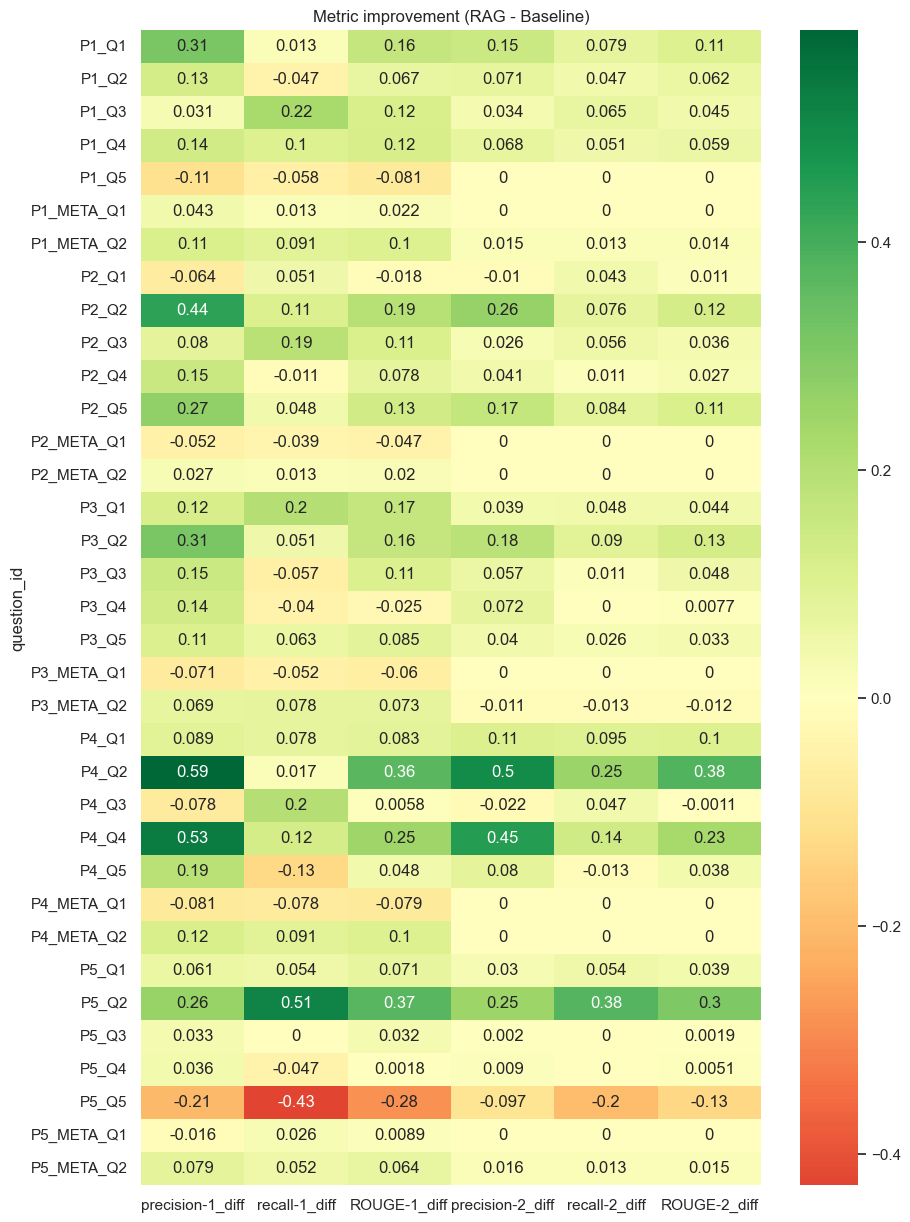

In [5]:
def plot_improvement_heatmap(df):
    heat_data = df.set_index('question_id')[[c + '_diff' for c in metric_cols]]
    plt.figure(figsize=(10, len(df)*0.4 + 1))
    sns.heatmap(heat_data, annot=True, cmap='RdYlGn', center=0)
    plt.title('Metric improvement (RAG - Baseline)')
    plt.show()

plot_improvement_heatmap(merged)

## Bar Chart by Question
Compare each metric for RAG and Baseline for a specific question.

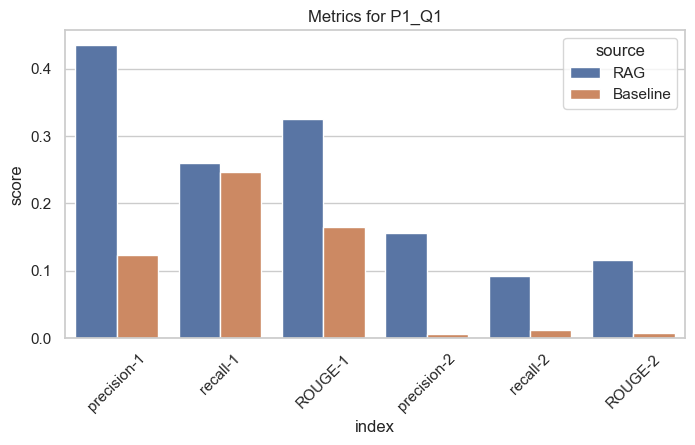

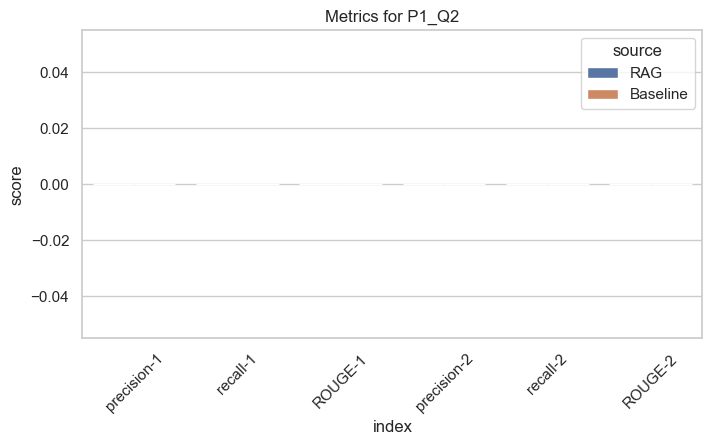

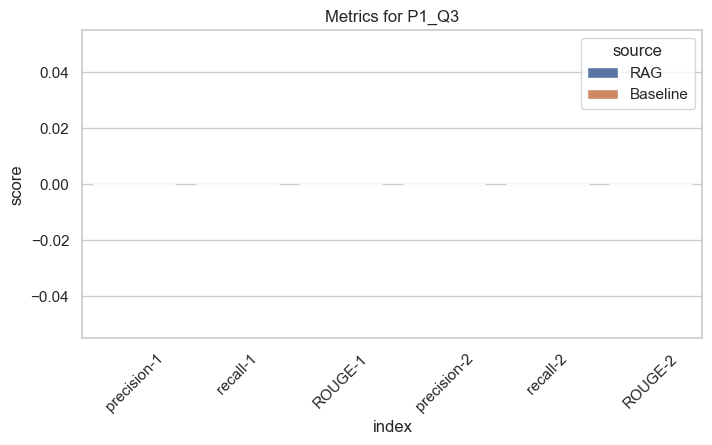

In [6]:
def plot_question_metrics(df, qid):
    data = df[df['question_id'] == qid]
    to_plot = data[[m + '_rag' for m in metric_cols] + [m + '_bl' for m in metric_cols]].T
    to_plot.index = metric_cols * 2
    to_plot['source'] = ['RAG']*len(metric_cols) + ['Baseline']*len(metric_cols)
    plt.figure(figsize=(8,4))
    sns.barplot(x='index', y=0, hue='source', data=to_plot.reset_index())
    plt.title(f'Metrics for {qid}')
    plt.xticks(rotation=45)
    plt.ylabel('score')
    plt.show()

_ = [plot_question_metrics(merged, q) for q in merged['question_id'].unique()[:3]]  # example

## Mean Metrics per Document
Aggregated metrics are averaged per paper (P1-P5).

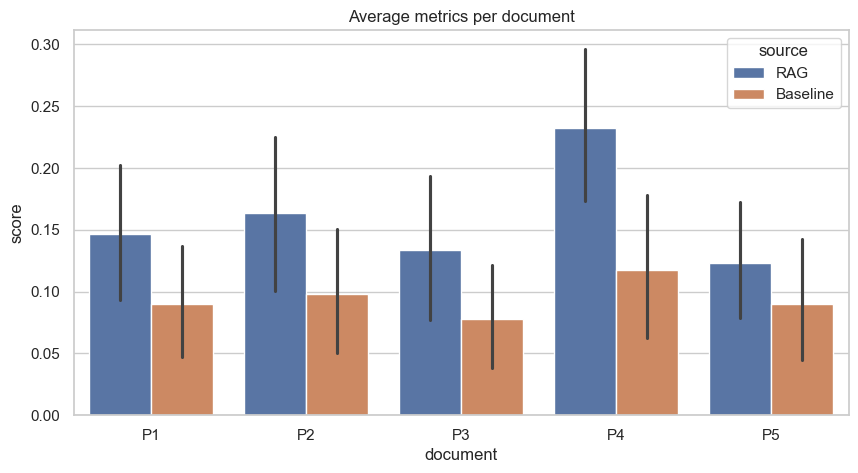

In [7]:
def plot_document_means(df):
    means = df.groupby('document')[[c + '_rag' for c in metric_cols] + [c + '_bl' for c in metric_cols]].mean()
    melted = means.reset_index().melt(id_vars='document', var_name='metric', value_name='score')
    melted['source'] = melted['metric'].apply(lambda x: 'RAG' if x.endswith('_rag') else 'Baseline')
    melted['metric'] = melted['metric'].str.replace('_rag','').str.replace('_bl','')
    plt.figure(figsize=(10,5))
    sns.barplot(data=melted, x='document', y='score', hue='source')
    plt.title('Average metrics per document')
    plt.show()

plot_document_means(merged)

## Boxplot of Improvements by Document


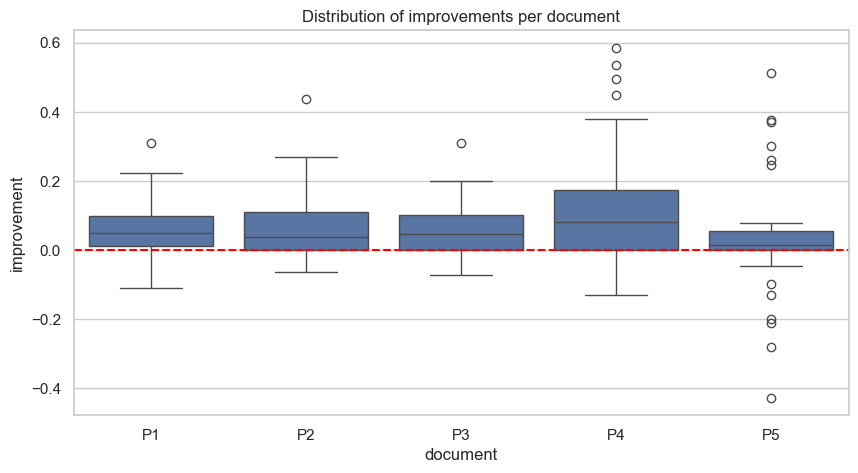

In [8]:
def plot_improvement_boxplot(df):
    diff_cols = [c + '_diff' for c in metric_cols]
    melted = df.melt(id_vars='document', value_vars=diff_cols, var_name='metric', value_name='improvement')
    plt.figure(figsize=(10,5))
    sns.boxplot(data=melted, x='document', y='improvement')
    plt.axhline(0, color='red', linestyle='--')
    plt.title('Distribution of improvements per document')
    plt.show()

plot_improvement_boxplot(merged)